# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
from scipy.stats import halfnorm
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_model_simple_bern, get_model_hierarchical_bern
from pyBasket.model import get_model_pyBasket, get_model_pyBasket_nc
from pyBasket.model import get_model_pyBasket_independent, get_model_pyBasket_independent_nc
from pyBasket.synthetic_data import generate_pyBasket_data

## 1. Generate some data

In [5]:
np.random.seed(42)

New generative process

In [6]:
results = generate_pyBasket_data(n_clusters=5)    
data_df = results['data_df']
true_basket_p = results['true_basket_p']
true_cluster_p = results['true_cluster_p']
true_interaction_p = results['true_interaction_p']
true_joint_p = results['true_joint_p']
n_tissues = results['n_tissues']
n_clusters = results['n_clusters']

In [7]:
data_df

,basket_number,cluster_number,responsive
0,6,3,1
1,19,0,1
2,14,4,1
3,10,1,1
4,7,1,1
...,...,...,...
495,4,0,0
496,11,1,0
497,15,3,1
498,15,2,1


In [8]:
true_basket_df = pd.DataFrame({'prob': true_basket_p, 'basket': range(len(true_basket_p))})
true_cluster_df = pd.DataFrame({'prob': true_cluster_p, 'cluster': range(len(true_cluster_p))})

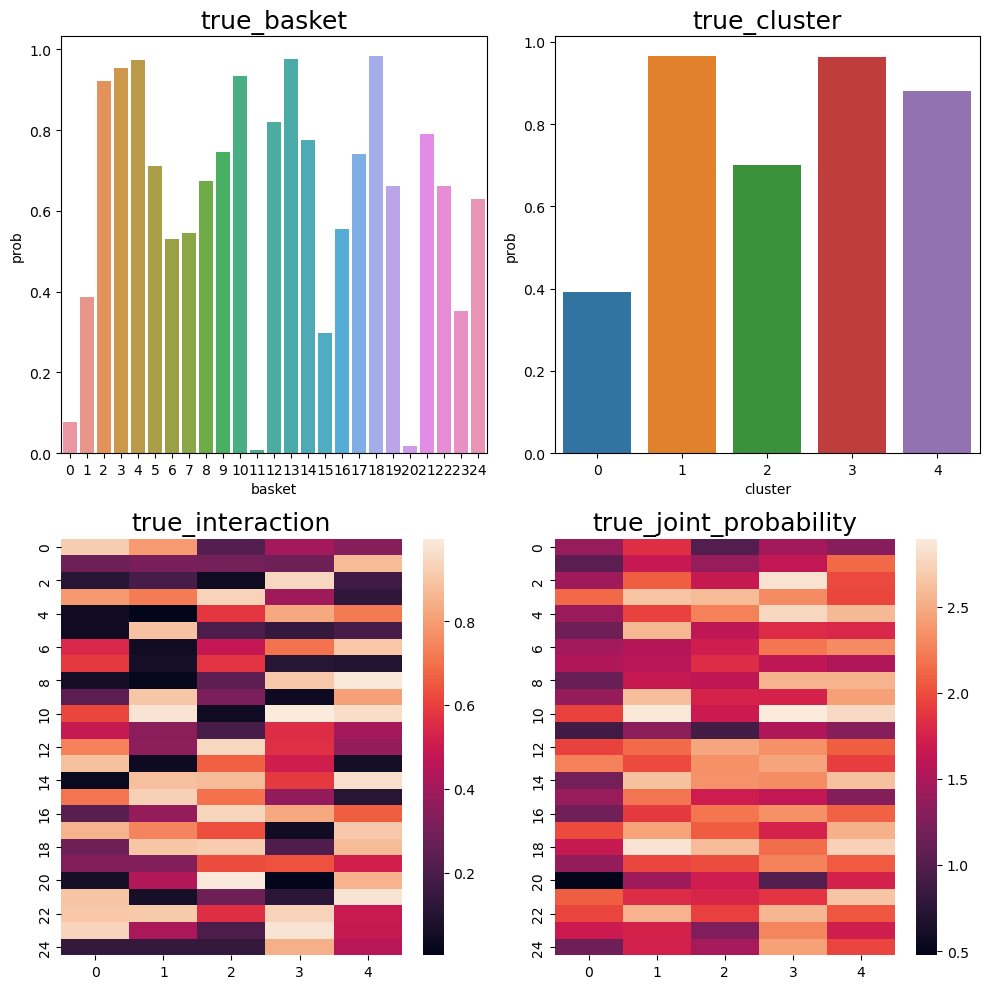

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax[0][0])
sns.barplot(data=true_cluster_df, x='cluster', y='prob', ax=ax[0][1])
sns.heatmap(true_interaction_p, ax=ax[1][0])
sns.heatmap(true_joint_p, ax=ax[1][1])

ax[0][0].set_title('true_basket', fontsize=18)
ax[0][1].set_title('true_cluster', fontsize=18)
ax[1][0].set_title('true_interaction', fontsize=18)
ax[1][1].set_title('true_joint_probability', fontsize=18)
plt.tight_layout()

## 2. Define models

No. of samples to collect before and after burn-in during MCMC.

In [10]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

The likelihood of a patient observation depends on the probability of their basket * cluster interaction, following a Bernoulli distribution with Beta priors.

Assumes that basket and cluster interaction probabilities are independent.

In [11]:
model_s = get_model_simple_bern(data_df, n_tissues, n_clusters)

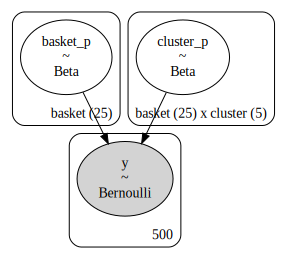

In [12]:
pm.model_to_graphviz(model_s)

In [13]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p, cluster_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 223 seconds.


In [14]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_p[0],0.66,0.17,0.39,1.00,0.0,0.0,15713.0,10005.0,1.0
basket_p[1],0.93,0.06,0.82,1.00,0.0,0.0,22798.0,10999.0,1.0
basket_p[2],0.94,0.06,0.83,1.00,0.0,0.0,18640.0,10693.0,1.0
basket_p[3],0.94,0.05,0.85,1.00,0.0,0.0,20454.0,10382.0,1.0
basket_p[4],0.92,0.07,0.79,1.00,0.0,0.0,18704.0,10250.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[24, 0]",0.15,0.14,0.00,0.40,0.0,0.0,22871.0,10695.0,1.0
"cluster_p[24, 1]",0.80,0.16,0.50,1.00,0.0,0.0,26618.0,10773.0,1.0
"cluster_p[24, 2]",0.29,0.22,0.00,0.71,0.0,0.0,30100.0,11510.0,1.0
"cluster_p[24, 3]",0.83,0.14,0.57,1.00,0.0,0.0,24048.0,9745.0,1.0


In [15]:
# az.plot_ess(
#     trace_s, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

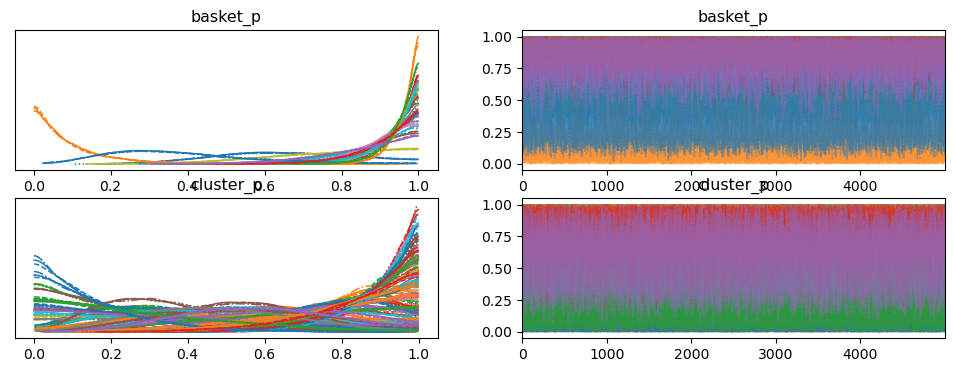

In [16]:
az.plot_trace(trace_s, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

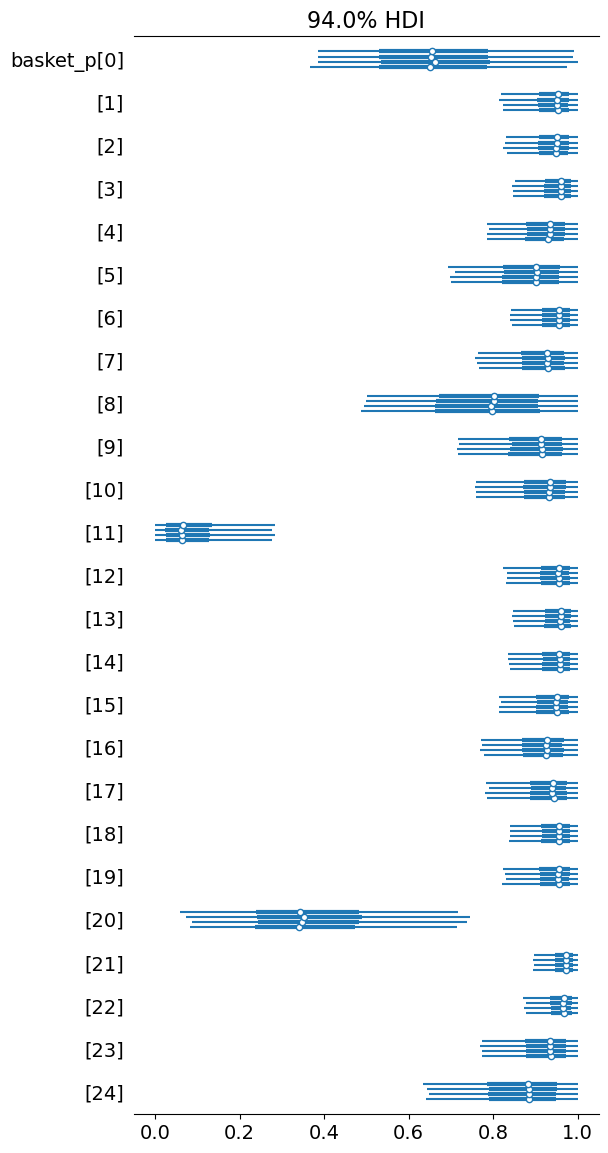

In [17]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [18]:
stacked_s = az.extract(trace_s)

In [19]:
inferred_basket_p = np.mean(stacked_s.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.3031414846282463)

In [20]:
inferred_cluster_p = np.mean(stacked_s.cluster_p.values, axis=2)
true_interaction_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_interaction_p, inferred_cluster_p))

((25, 5), (25, 5), 0.33795601192386665)

### pyBasket model (initial)

Same as above but add priors.

In [22]:
model_h1 = get_model_pyBasket_independent(data_df, n_tissues, n_clusters)

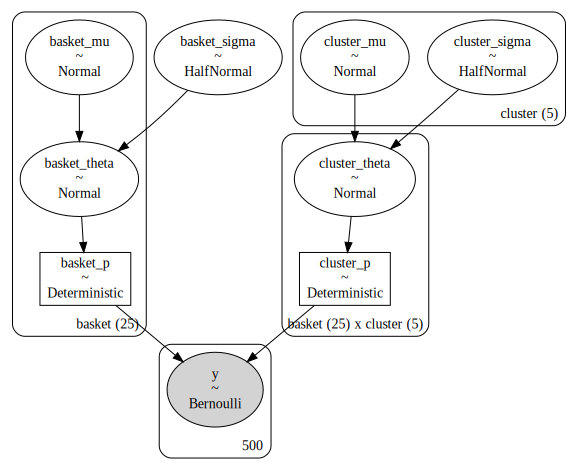

In [23]:
pm.model_to_graphviz(model_h1)

In [24]:
# with model_h1:
#     trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

This is the one we actually use after reparameterisation.

In [25]:
model_h1_nc = get_model_pyBasket_independent_nc(data_df, n_tissues, n_clusters)

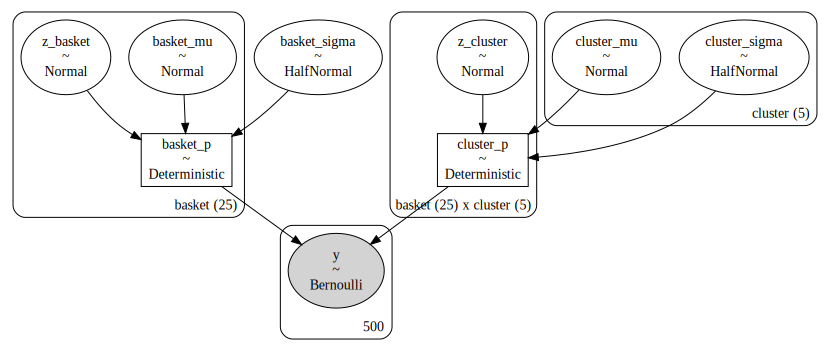

In [26]:
pm.model_to_graphviz(model_h1_nc)

In [27]:
with model_h1_nc:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 492 seconds.


In [28]:
az.summary(trace_h1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[0],-0.08,0.63,-1.27,1.09,0.01,0.0,12006.0,12135.0,1.0
z_basket[1],1.02,0.76,-0.40,2.44,0.01,0.0,18257.0,15035.0,1.0
z_basket[2],0.86,0.73,-0.47,2.30,0.01,0.0,12584.0,14630.0,1.0
z_basket[3],1.07,0.74,-0.31,2.47,0.01,0.0,17869.0,13559.0,1.0
z_basket[4],0.76,0.73,-0.64,2.12,0.01,0.0,14962.0,14223.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[24, 0]",0.19,0.17,0.00,0.53,0.00,0.0,16686.0,11218.0,1.0
"cluster_p[24, 1]",0.96,0.04,0.91,1.00,0.00,0.0,17193.0,14335.0,1.0
"cluster_p[24, 2]",0.54,0.29,0.07,1.00,0.00,0.0,13892.0,12834.0,1.0
"cluster_p[24, 3]",0.98,0.02,0.94,1.00,0.00,0.0,21126.0,14431.0,1.0


In [29]:
# az.plot_ess(
#     trace_h1, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

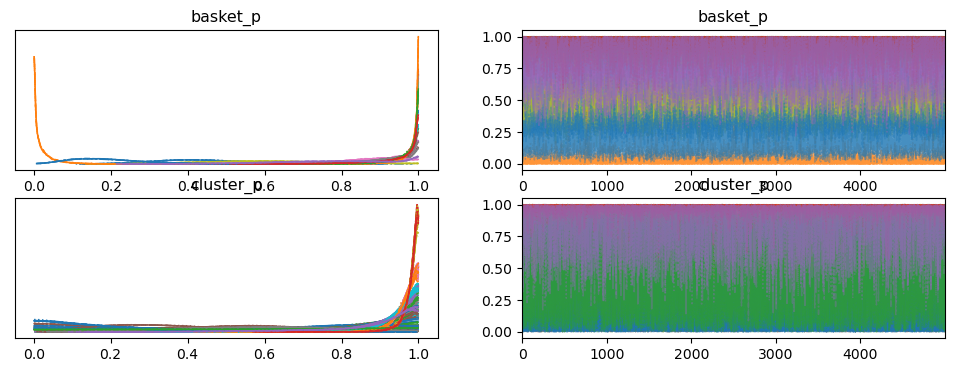

In [30]:
az.plot_trace(trace_h1, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

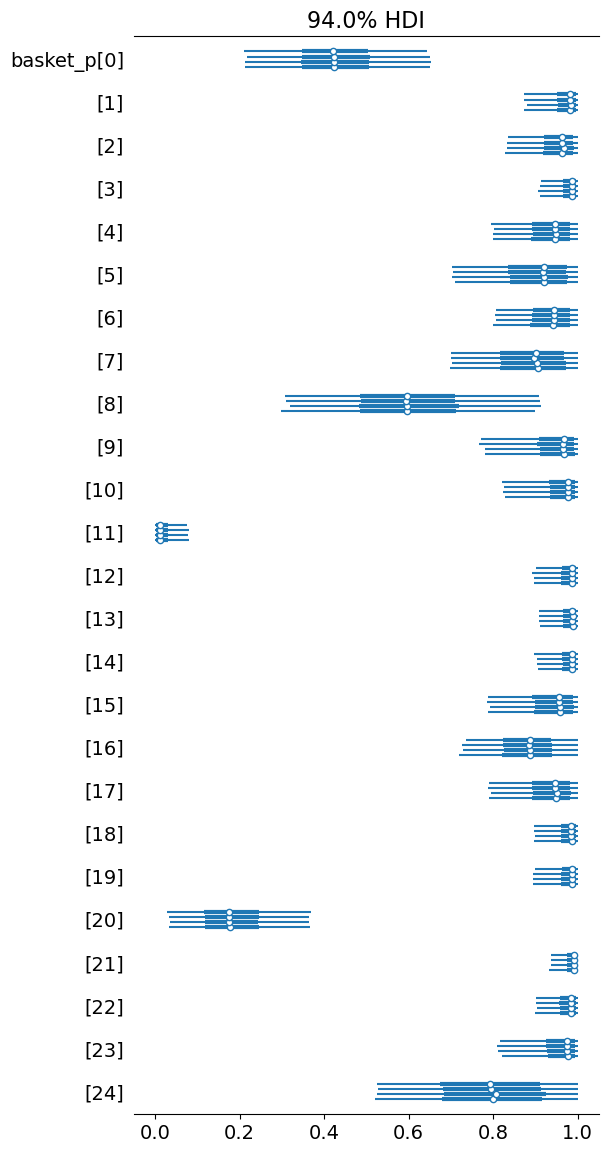

In [31]:
az.plot_forest(trace_h1, var_names=['basket_p'])

In [32]:
stacked_h1 = az.extract(trace_h1)

In [33]:
inferred_basket_p = np.mean(stacked_h1.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.2858018166340436)

In [34]:
inferred_cluster_p = np.mean(stacked_h1.cluster_p.values, axis=2)
true_interaction_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_interaction_p, inferred_cluster_p))

((25, 5), (25, 5), 0.46501755276447365)

In [35]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (n_clusters, 1)).T
inferred_mat_h1 = inferred_basket_p_tiled * inferred_cluster_p
true_joint_p.shape, inferred_basket_p_tiled.shape, inferred_mat_h1.shape

((25, 5), (25, 5), (25, 5))

### pyBasket model (logistic regression)

Should be the final version used in the paper.

In [36]:
model_pyBasket = get_model_pyBasket(data_df, n_tissues, n_clusters)

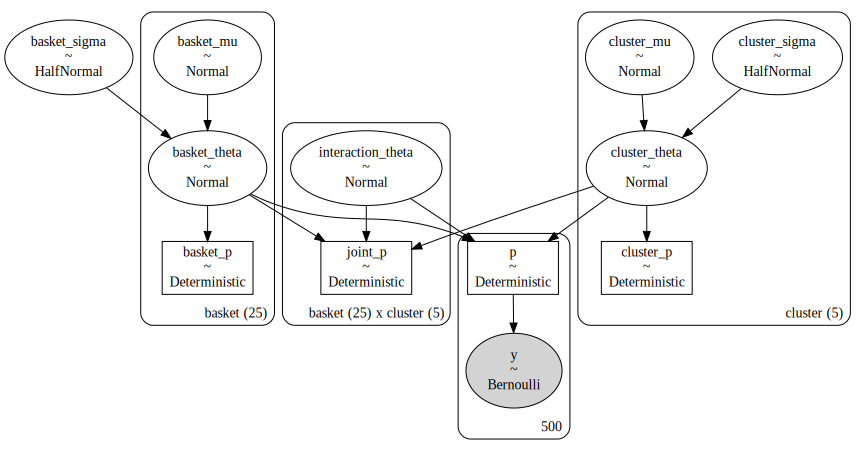

In [37]:
pm.model_to_graphviz(model_pyBasket)

In [38]:
# with model_pyBasket:
#     trace_pyBasket = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [39]:
model_pyBasket_nc = get_model_pyBasket_nc(data_df, n_tissues, n_clusters)

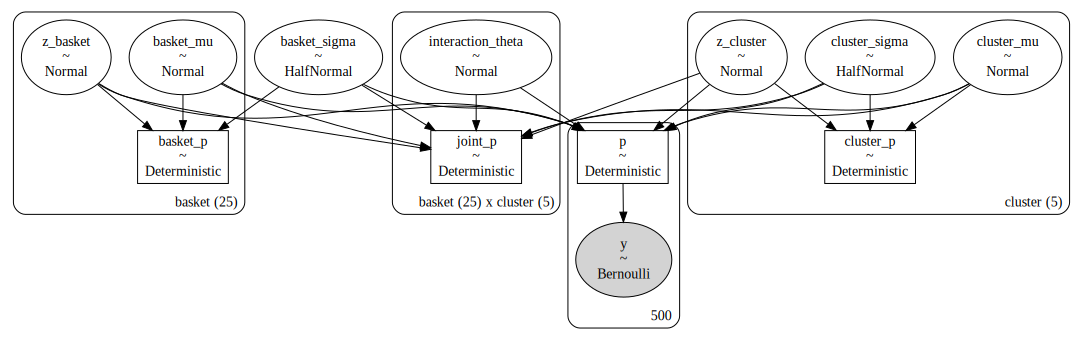

In [40]:
pm.model_to_graphviz(model_pyBasket_nc)

In [41]:
with model_pyBasket_nc:
    trace_pyBasket = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma, interaction_theta]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 803 seconds.


In [42]:
az.summary(trace_pyBasket).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[0],-0.35,0.95,-2.12,1.47,0.01,0.01,29473.0,15668.0,1.0
z_basket[1],0.03,0.92,-1.70,1.76,0.00,0.01,33102.0,16713.0,1.0
z_basket[2],0.03,0.92,-1.66,1.80,0.00,0.01,33529.0,15511.0,1.0
z_basket[3],0.50,0.99,-1.37,2.32,0.01,0.01,22879.0,15873.0,1.0
z_basket[4],0.03,0.92,-1.74,1.72,0.00,0.01,37806.0,15033.0,1.0
...,...,...,...,...,...,...,...,...,...
p[495],0.20,0.20,0.00,0.59,0.00,0.00,37949.0,14936.0,1.0
p[496],0.07,0.10,0.00,0.26,0.00,0.00,26577.0,15401.0,1.0
p[497],0.96,0.07,0.85,1.00,0.00,0.00,38244.0,15048.0,1.0
p[498],0.90,0.11,0.70,1.00,0.00,0.00,37011.0,15666.0,1.0


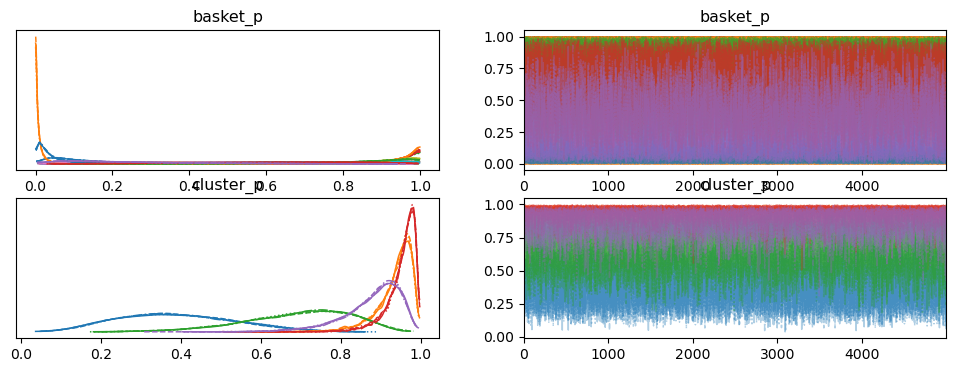

In [43]:
az.plot_trace(trace_pyBasket, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

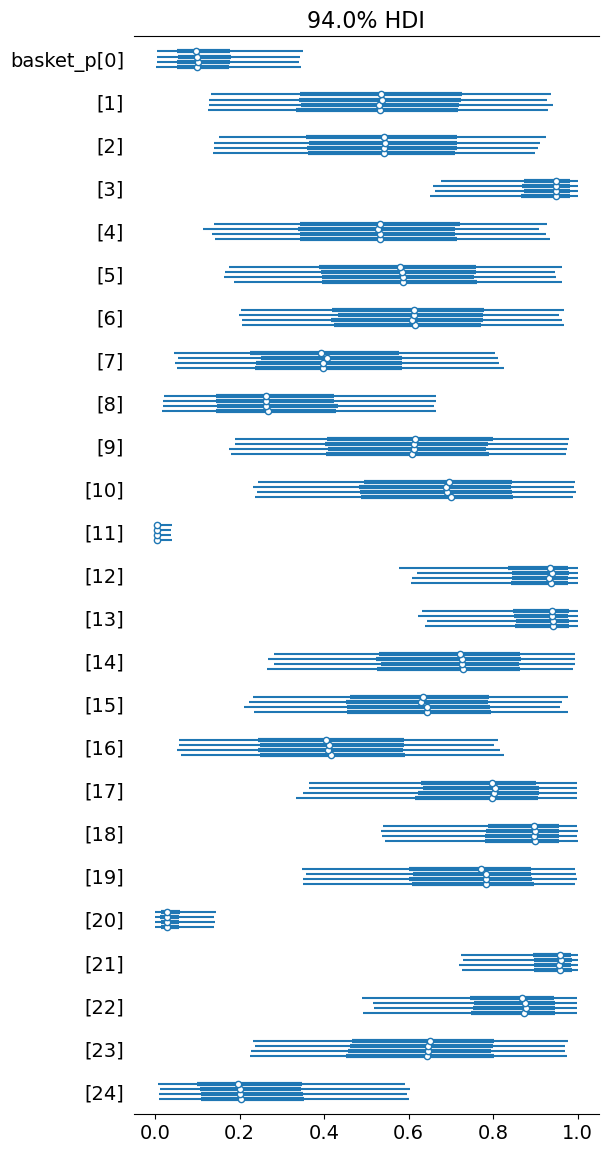

In [44]:
az.plot_forest(trace_pyBasket, var_names=['basket_p'])

In [45]:
stacked_pyBasket = az.extract(trace_pyBasket)

In [46]:
inferred_basket_p = np.mean(stacked_pyBasket.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.20773555371354635)

In [47]:
inferred_cluster_p = np.mean(stacked_pyBasket.cluster_p.values, axis=1)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((5,), (5,), 0.014619779536751448)

In [48]:
inferred_joint_p = np.mean(stacked_pyBasket.joint_p.values, axis=2)
true_joint_p.shape, inferred_joint_p.shape, math.sqrt(mean_squared_error(true_joint_p, inferred_joint_p))

((25, 5), (25, 5), 1.2368290614470867)

## 3. Calculate RMSE

Calculate root mean squared error for basket_p

In [49]:
actual = true_basket_p

predicted_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
predicted_basket_s_df = pd.DataFrame({'prob': predicted_basket_s, 'basket': range(len(predicted_basket_s))})
rmse_s = math.sqrt(mean_squared_error(actual, predicted_basket_s))

predicted_basket_h1 = np.mean(stacked_h1.basket_p.values, axis=1)
predicted_basket_h1_df = pd.DataFrame({'prob': predicted_basket_h1, 'basket': range(len(predicted_basket_h1))})
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted_basket_h1))

predicted_basket_h2 = np.mean(stacked_pyBasket.basket_p.values, axis=1)
predicted_basket_h2_df = pd.DataFrame({'prob': predicted_basket_h2, 'basket': range(len(predicted_basket_h2))})
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_basket_h2))

rmse_basket_p = pd.DataFrame({
    'method': ['simple', 'hierarchical', 'pyBasket'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_basket_p

,method,RMSE
0,simple,0.303141
1,hierarchical,0.285802
2,pyBasket,0.207736


Calculate root mean squared error for the joint probabilities

In [50]:
actual = true_joint_p

predicted_cluster_s = inferred_mat_s
rmse_s = math.sqrt(mean_squared_error(actual, predicted_cluster_s))

predicted_cluster_h1 = inferred_mat_h1
rmse_h1 = math.sqrt(mean_squared_error(actual, predicted_cluster_h1))

predicted_cluster_h2 = inferred_joint_p
rmse_h2 = math.sqrt(mean_squared_error(actual, predicted_cluster_h2))

rmse_cluster_p = pd.DataFrame({
    'method': ['simple', 'hierarchical', 'pyBasket'],
    'RMSE': [rmse_s, rmse_h1, rmse_h2]
})
rmse_cluster_p

,method,RMSE
0,simple,1.375776
1,hierarchical,1.260257
2,pyBasket,1.236829


Make plot

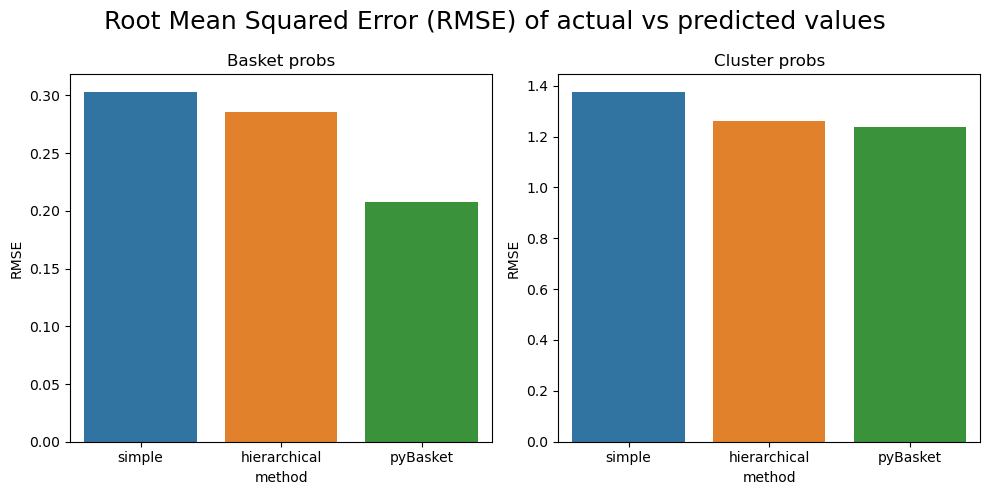

In [51]:
methods = rmse_basket_p['method'].unique()
colors = sns.color_palette("deep", len(methods))
color_map = dict(zip(methods, colors))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.barplot(x='method', y='RMSE', data=rmse_basket_p, ax=ax1)
ax1.set_title('Basket probs')

sns.barplot(x='method', y='RMSE', data=rmse_cluster_p, ax=ax2)
ax2.set_title('Cluster probs')

plt.suptitle('Root Mean Squared Error (RMSE) of actual vs predicted values', size=18)
plt.tight_layout()

Compare the matrices

Text(0.5, 1.0, 'Inferred (pyBasket)')

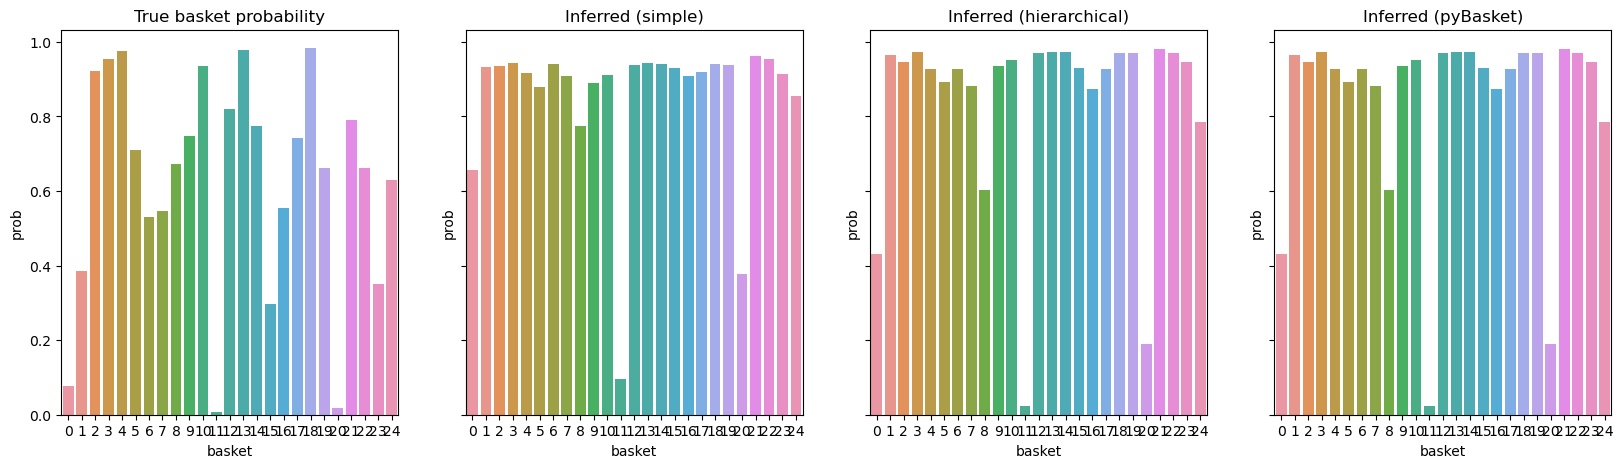

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax[0])
ax[0].set_title('True basket probability')

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[1])
ax[1].set_title('Inferred (simple)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[3])
ax[3].set_title('Inferred (pyBasket)')

Text(1452.626811594203, 0.5, 'Baskets')

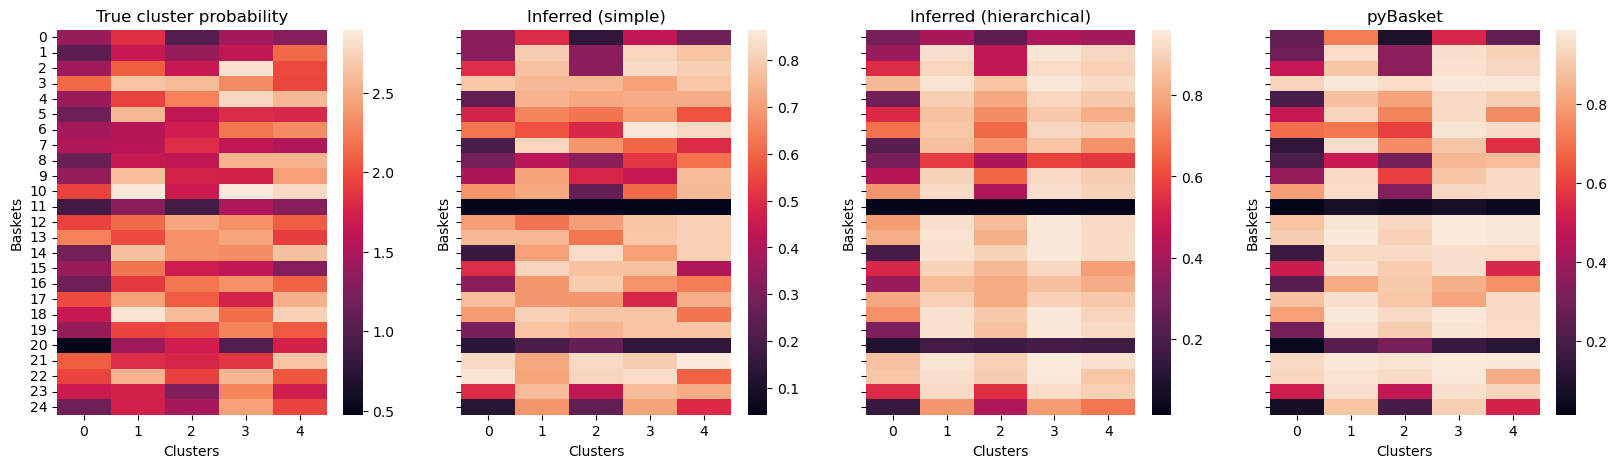

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

sns.heatmap(true_joint_p, ax=ax[0])
ax[0].set_title('True cluster probability')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_s, ax=ax[1])
ax[1].set_title('Inferred (simple)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_h1, ax=ax[2])
ax[2].set_title('Inferred (hierarchical)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_h2, ax=ax[3])
ax[3].set_title('pyBasket')
ax[3].set_xlabel('Clusters')
ax[3].set_ylabel('Baskets')

Check top and bottom partitions

In [55]:
def get_indices(arr, N):
    # Get the indices of the top-3 largest values
    top_indices = np.argpartition(arr, -N, axis=None)[-N:]
    top_indices = np.unravel_index(top_indices, arr.shape)

    # Get the indices of the top-3 smallest values
    bottom_indices = np.argpartition(arr, N, axis=None)[:N]
    bottom_indices = np.unravel_index(bottom_indices, arr.shape)

    return top_indices, bottom_indices

In [56]:
def count_overlap(true_indices, inferred_indices):
    a = set(zip(true_indices[0], true_indices[1]))
    b = set(zip(inferred_indices[0], inferred_indices[1]))
    return a.intersection(b)

In [57]:
plot_data = []
for N in list(range(5, 55, 5)):

    true_top_indices, true_bottom_indices = get_indices(true_joint_p, N)

    inferred_top_indices_s, inferred_bottom_indices_s = get_indices(inferred_mat_s, N)
    inferred_top_indices_h1, inferred_bottom_indices_h1 = get_indices(inferred_mat_h1, N)
    inferred_top_indices_h2, inferred_bottom_indices_h2 = get_indices(inferred_joint_p, N)

    top_overlap_s = len(count_overlap(true_top_indices, inferred_top_indices_s))
    bottom_overlap_s = len(count_overlap(true_bottom_indices, inferred_bottom_indices_s))    
    plot_data.append(['s', top_overlap_s, bottom_overlap_s, (top_overlap_s+bottom_overlap_s), N])

    top_overlap_h1 = len(count_overlap(true_top_indices, inferred_top_indices_h1))
    bottom_overlap_h1 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h1))
    plot_data.append(['h1', top_overlap_h1, bottom_overlap_h1, (top_overlap_h1+bottom_overlap_h1), N])

    top_overlap_h2 = len(count_overlap(true_top_indices, inferred_top_indices_h2))
    bottom_overlap_h2 = len(count_overlap(true_bottom_indices, inferred_bottom_indices_h2))
    plot_data.append(['h2', top_overlap_h2, bottom_overlap_h2, (top_overlap_h2+bottom_overlap_h2), N])
    
df = pd.DataFrame(plot_data, columns=['method', 'top', 'bottom', 'total', 'N'])
df

,method,top,bottom,total,N
0,s,0,2,2,5
1,h1,0,2,2,5
2,h2,0,3,3,5
3,s,2,6,8,10
4,h1,0,4,4,10
5,h2,2,5,7,10
6,s,3,8,11,15
7,h1,3,8,11,15
8,h2,3,9,12,15
9,s,5,12,17,20


Text(0.5, 1.0, 'Correct most-responsive partitions')

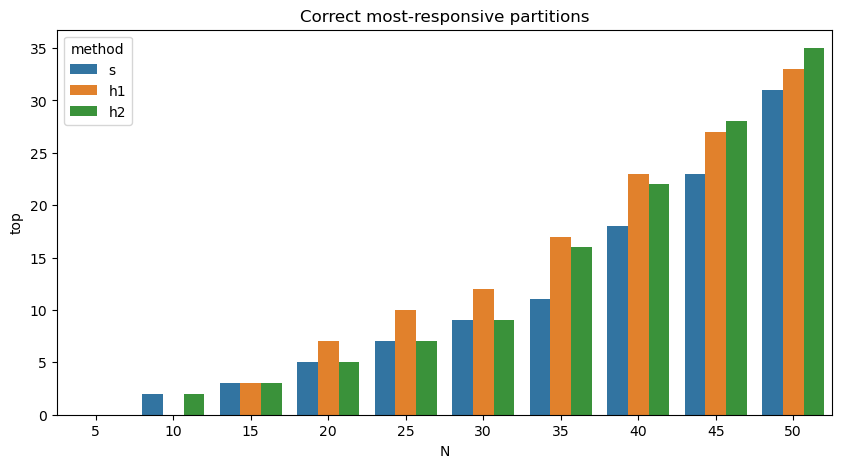

In [58]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='top', data=df, hue='method')
plt.title('Correct most-responsive partitions')

Text(0.5, 1.0, 'Correct least-responsive partitions')

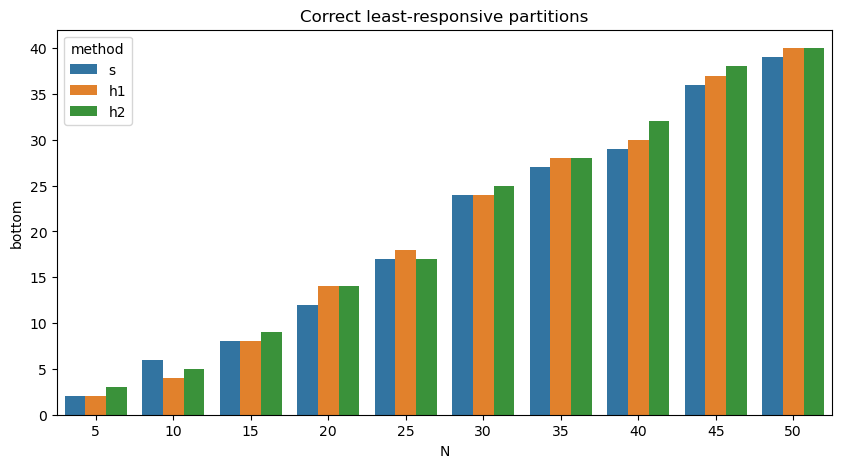

In [59]:
plt.figure(figsize=(10, 5))
sns.barplot(x='N', y='bottom', data=df, hue='method')
plt.title('Correct least-responsive partitions')

## 4. Model comparison

In [60]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [61]:
loo_s = az.loo(trace_s)
loo_s

Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -221.98     7.81
p_loo       42.63        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      495   99.0%
 (0.5, 0.7]   (ok)          5    1.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [62]:
loo_h1 = az.loo(trace_h1)
loo_h1

Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -184.85    11.32
p_loo       32.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      486   97.2%
 (0.5, 0.7]   (ok)         14    2.8%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [63]:
loo_h2 = az.loo(trace_pyBasket)
loo_h2

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -176.03    13.24
p_loo       52.54        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      475   95.0%
 (0.5, 0.7]   (ok)         24    4.8%
   (0.7, 1]   (bad)         1    0.2%
   (1, Inf)   (very bad)    0    0.0%

In [64]:
ic = 'loo'
df_comp_loo = az.compare({
    'simple': loo_s, 
    'hierarchical': loo_h1,
    'pyBasket': loo_h2,    
}, ic=ic)
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pyBasket,0,-176.030655,52.535093,0.000000,0.895309,13.243578,0.000000,True,log
hierarchical,1,-184.851073,32.994225,8.820418,0.094872,11.322544,4.702076,False,log
simple,2,-221.978722,42.630012,45.948067,0.009819,7.814809,7.777952,False,log


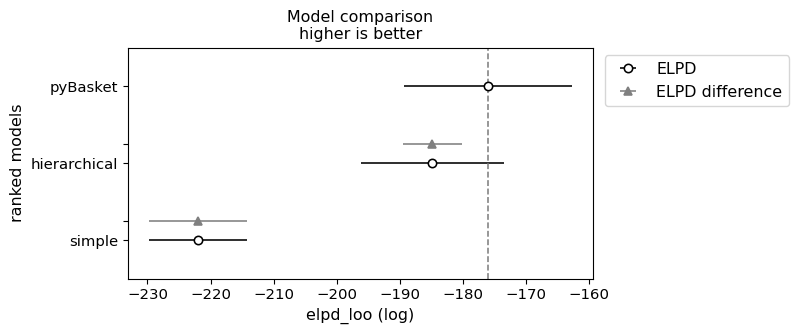

In [65]:
az.plot_compare(df_comp_loo);